<a href="https://colab.research.google.com/github/Excelfthn/DIP_Assignment_03/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Otsu Segmentation Method

## Importing Required Libraries

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


Some libraries were used, but not for segmentation or morphological processing. NumPy was used for matrix operations, PIL for loading and converting images to grayscale, and Matplotlib for visualizing both images and histograms.

## Defining the Otsu Threshold Function

In [ ]:
def otsu_threshold(image):

    if image.ndim != 2:
        raise ValueError("otsu_threshold expects a 2D grayscale image")

    hist, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    hist = hist.astype(np.float64)
    total = hist.sum()
    if total == 0:
        return 0, np.zeros_like(image, dtype=bool)

    p = hist / total
    bins = np.arange(256)
    omega = np.cumsum(p)
    mu = np.cumsum(p * bins)
    mu_t = mu[-1]

    numerator = (mu_t * omega - mu) ** 2
    denominator = omega * (1.0 - omega)
    denominator[denominator == 0] = 1e-10
    sigma_b_squared = numerator / denominator

    t_opt = np.argmax(sigma_b_squared)
    binary = image > t_opt
    return int(t_opt), binary


Calculates the optimal threshold that separates foreground and background based on pixel intensity distribution. It builds the histogram, normalizes it to probability, computes cumulative means, and selects the threshold that maximizes the between-class variance, producing both the threshold value and the binary image.

## Loading and Applying Otsu Segmentation

In [ ]:
path = "/content/coins.jpg"  # image path
img = np.array(Image.open(path).convert("L"))  # convert to grayscale
thr, bw = otsu_threshold(img)

print(f"Otsu Threshold = {thr}")


Otsu Threshold = 172


Loads the input image and converts it into an 8 bit grayscale array, ensuring that each pixel value ranges from 0 to 255. The grayscale image is then processed using the Otsu thresholding algorithm to automatically determine the optimal intensity value that separates the foreground (coins) from the background. In this case, the computed threshold value is 172, which represents the pixel intensity level used to divide the image into two distinct regions for segmentation.

## Visualizing Otsu Segmentation Results

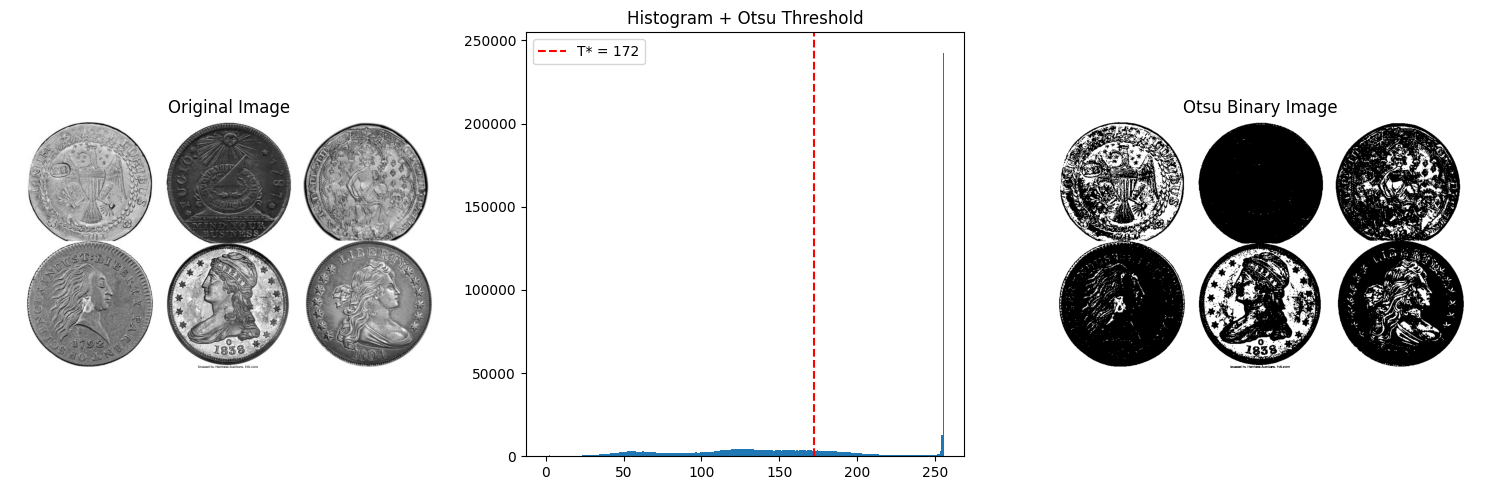

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original grayscale image
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

# Histogram with threshold line
ax[1].hist(img.ravel(), bins=256, range=(0, 256))
ax[1].axvline(thr, color="r", ls="--", label=f"T* = {thr}")
ax[1].set_title("Histogram + Otsu Threshold")
ax[1].legend()

# Binary (Otsu) image
ax[2].imshow(bw, cmap="gray")
ax[2].set_title("Otsu Binary Image")
ax[2].axis("off")

plt.tight_layout()
plt.show()


From the segmentation results, we can see the original grayscale image in the first panel, the second panel shows its histogram with a red dashed line marking the Otsu threshold at 172, and the third panel displays the binary image produced after thresholding.

# Morphological Operation (Erosion, Dilation, Opening)

## Defining Morphological Functions

In [ ]:

SE = [[1,1,1],
      [1,1,1],
      [1,1,1]]

def _se_offsets(se):
    h, w = len(se), len(se[0])
    cy, cx = h//2, w//2
    return [(dy-cy, dx-cx) for dy in range(h) for dx in range(w) if se[dy][dx]==1]

_OFF = _se_offsets(SE)

def _pad(img, pad_y, pad_x, val=0):
    H, W = len(img), len(img[0])
    out = [[val]*(W+2*pad_x) for _ in range(H+2*pad_y)]
    for y in range(H):
        row = img[y]
        out[y+pad_y][pad_x:pad_x+W] = row[:]
    return out

def erode_binary(img, se_offsets=_OFF):
    #Binary erosion (0/1) with zero-padding
    H, W = len(img), len(img[0])
    pad_y = max(abs(dy) for dy,_ in se_offsets)
    pad_x = max(abs(dx) for _,dx in se_offsets)
    src = _pad(img, pad_y, pad_x, 0)
    out = [[0]*W for _ in range(H)]
    for y in range(H):
        for x in range(W):
            keep = 1
            sy, sx = y+pad_y, x+pad_x
            for dy,dx in se_offsets:
                if src[sy+dy][sx+dx] == 0:
                    keep = 0; break
            out[y][x] = keep
    return out

def dilate_binary(img, se_offsets=_OFF):
    #Binary dilation (0/1) with zero-padding
    H, W = len(img), len(img[0])
    pad_y = max(abs(dy) for dy,_ in se_offsets)
    pad_x = max(abs(dx) for _,dx in se_offsets)
    src = _pad(img, pad_y, pad_x, 0)
    out = [[0]*W for _ in range(H)]
    for y in range(H):
        for x in range(W):
            val = 0
            sy, sx = y+pad_y, x+pad_x
            for dy,dx in se_offsets:
                if src[sy+dy][sx+dx] == 1:
                    val = 1; break
            out[y][x] = val
    return out

def opening_binary(img, se_offsets=_OFF):
    #Opening = erosion then do dilation
    return dilate_binary(erode_binary(img, se_offsets), se_offsets)


The code first defines a 3×3 structuring element (**SE**) of ones, which acts as a kernel for modifying pixels in the binary image. The **_se_offsets()** function calculates the relative positions of active pixels in the structuring element, **while _pad()** adds a zero border around the image to handle edges safely.

The **erode_binary()** function performs erosion, setting a pixel to 1 only if all its neighbors under the structuring element are 1, which removes small noise and shrinks bright areas. The **dilate_binary()** function performs dilation, setting a pixel to 1 if any neighboring pixel is 1, expanding bright regions and filling gaps. The **opening_binary()** function combines both operations, erosion followed by dilation, to clean noise while preserving object shapes.

## Running and Visualizing Morphological Results

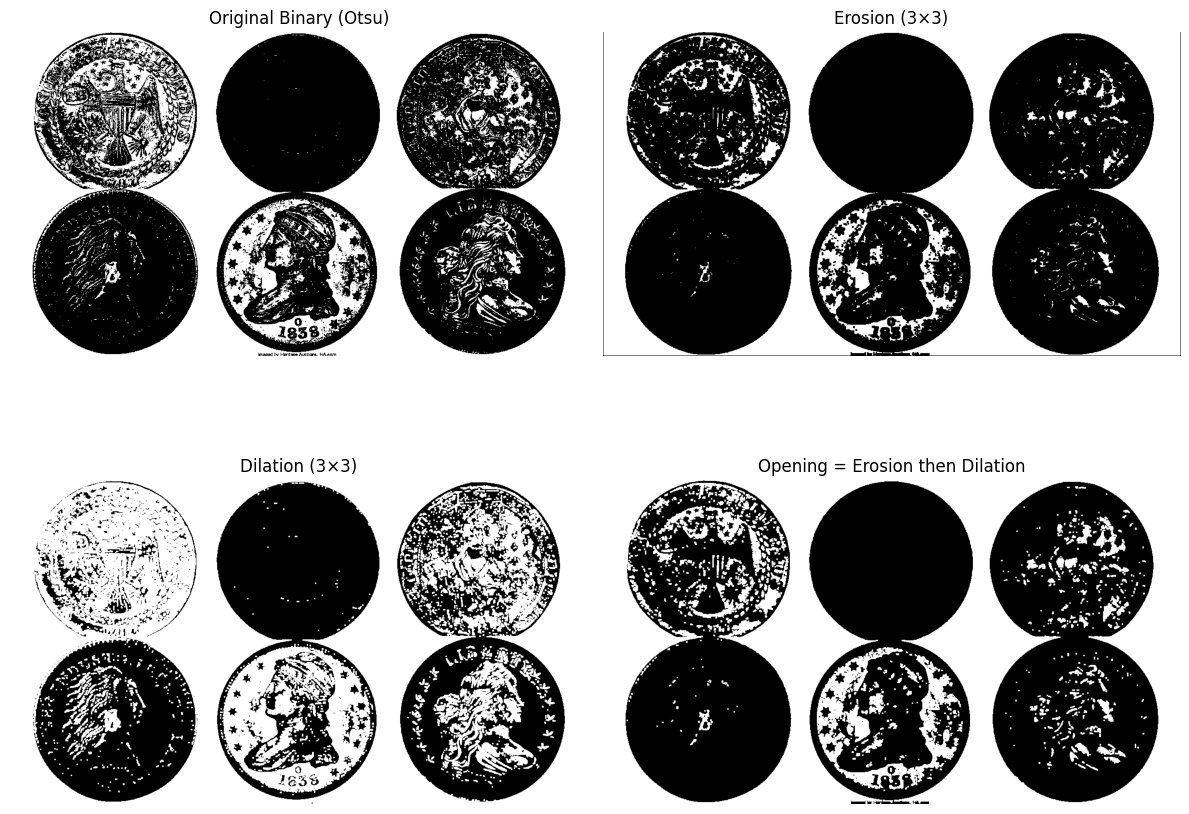

In [ ]:
# convert boolean numpy array to plain 0/1 Python lists for processing
bin_list = [[1 if v else 0 for v in row] for row in bw.tolist()]

eroded  = erode_binary(bin_list)
dilated = dilate_binary(bin_list)
opened  = opening_binary(bin_list)

e_np = np.array(eroded,  dtype=np.uint8)
d_np = np.array(dilated, dtype=np.uint8)
o_np = np.array(opened,  dtype=np.uint8)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0,0].imshow(bw, cmap="gray"); ax[0,0].set_title("Original Binary (Otsu)"); ax[0,0].axis("off")
ax[0,1].imshow(e_np, cmap="gray"); ax[0,1].set_title("Erosion (3×3)");        ax[0,1].axis("off")
ax[1,0].imshow(d_np, cmap="gray"); ax[1,0].set_title("Dilation (3×3)");       ax[1,0].axis("off")
ax[1,1].imshow(o_np, cmap="gray"); ax[1,1].set_title("Opening = Erosion then Dilation"); ax[1,1].axis("off")
plt.tight_layout(); plt.show()


From the segmentation results, the are differences between the image processed with and without morphological operations. The original Otsu binary image shows the coins segmented from the background, but it still contains small noise and irregular edges. After applying erosion, much of the small white noise is removed, and the edges of the coins become thinner, although some fine details may also be lost. The subsequent dilation step restores the general size and shape of the coins while filling small gaps, improving the continuity of the object boundaries. When both operations are combined in the opening process (erosion followed by dilation), the result is a cleaner and smoother segmentation with reduced noise and better-defined coin regions. Overall, morphological processing enhances the Otsu segmentation by refining the binary image, reducing unwanted noise, and producing more distinct object boundaries.